ZHVI dataset comes from https://www.kaggle.com/datasets/paultimothymooney/zillow-house-price-data?select=Sale_Prices_City.csv

Unemployment rate dataset comes from https://www.kaggle.com/datasets/axeltorbenson/unemployment-data-19482021

Inflation Rate(CPI) Dataset https://www.kaggle.com/datasets/varpit94/us-inflation-data-updated-till-may-2021

Interest rate dataset https://www.kaggle.com/datasets/raoofiali/us-interest-rate-weekly

GDP Growth Rate dataset https://www.kaggle.com/datasets/rajkumarpandey02/economy-of-the-united-states

In [ ]:
#!pip install ydata-profiling
#!pip install tensorflow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import kagglehub
import math
import os
import warnings

#from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, r2_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense
from IPython.display import clear_output, display, HTML

warnings.filterwarnings("ignore")
clear_output()

Adding Housing Data

In [ ]:
# Download housing data
path = kagglehub.dataset_download("paultimothymooney/zillow-house-price-data")

print("Files in the dataset:")
for root, dirs, files in os.walk(path):
    for file in files:
        print(os.path.join(root, file))

100%|██████████| 124M/124M [00:02<00:00, 58.4MB/s]

Extracting files...


Files in the dataset:
/root/.cache/kagglehub/datasets/paultimothymooney/zillow-house-price-data/versions/14/City_Zri_SingleFamilyResidenceRental.csv
/root/.cache/kagglehub/datasets/paultimothymooney/zillow-house-price-data/versions/14/State_MedianRentalPrice_2Bedroom.csv
/root/.cache/kagglehub/datasets/paultimothymooney/zillow-house-price-data/versions/14/City_Zhvi_SingleFamilyResidence.csv
/root/.cache/kagglehub/datasets/paultimothymooney/zillow-house-price-data/versions/14/City_Zhvi_AllHomes.csv
/root/.cache/kagglehub/datasets/paultimothymooney/zillow-house-price-data/versions/14/DaysOnZillow_State.csv
/root/.cache/kagglehub/datasets/paultimothymooney/zillow-house-price-data/versions/14/State_Zhvi_Condominum.csv
/root/.cache/kagglehub/datasets/paultimothymooney/zillow-house-price-data/versions/14/State_MedianRentalPrice_AllHomes.csv
/root/.cache/kagglehub/datasets/paultimothymooney/zillow-house-price-data/versions/14/City_MedianRentalPrice_5BedroomOrMore.csv
/root/.cache/kagglehub/da

In [ ]:
csv_path = os.path.join(path, "City_Zhvi_AllHomes.csv")
df = pd.read_csv(csv_path)
print(df.head())

   Unnamed: 0  RegionID  SizeRank   RegionName RegionType StateName State  \
0           0      6181         0     New York       City        NY    NY   
1           1     12447         1  Los Angeles       City        CA    CA   
2           2     39051         2      Houston       City        TX    TX   
3           3     17426         3      Chicago       City        IL    IL   
4           4      6915         4  San Antonio       City        TX    TX   

                              Metro          CountyName  1996-01-31  ...  \
0       New York-Newark-Jersey City       Queens County    196258.0  ...   
1    Los Angeles-Long Beach-Anaheim  Los Angeles County    185649.0  ...   
2  Houston-The Woodlands-Sugar Land       Harris County     93518.0  ...   
3          Chicago-Naperville-Elgin         Cook County    130920.0  ...   
4         San Antonio-New Braunfels        Bexar County     94041.0  ...   

   2019-06-30  2019-07-31  2019-08-31  2019-09-30  2019-10-31  2019-11-30  \
0  

In [ ]:
# remove rows with NaN
df_cleaned = df.dropna()
print("DataFrame after removing rows with any NaN values:")
print(df_cleaned.head())
data = df_cleaned

DataFrame after removing rows with any NaN values:
   Unnamed: 0  RegionID  SizeRank   RegionName RegionType StateName State  \
0           0      6181         0     New York       City        NY    NY   
1           1     12447         1  Los Angeles       City        CA    CA   
2           2     39051         2      Houston       City        TX    TX   
3           3     17426         3      Chicago       City        IL    IL   
4           4      6915         4  San Antonio       City        TX    TX   

                              Metro          CountyName  1996-01-31  ...  \
0       New York-Newark-Jersey City       Queens County    196258.0  ...   
1    Los Angeles-Long Beach-Anaheim  Los Angeles County    185649.0  ...   
2  Houston-The Woodlands-Sugar Land       Harris County     93518.0  ...   
3          Chicago-Naperville-Elgin         Cook County    130920.0  ...   
4         San Antonio-New Braunfels        Bexar County     94041.0  ...   

   2019-06-30  2019-07-31  20

In [ ]:
# Remove location identifier since only one city has data for each month/year
data.drop('State',axis=1,inplace=True)
data.drop('CountyName',axis=1,inplace=True)
data.drop('SizeRank',axis=1,inplace=True)
data.drop('Metro',axis=1,inplace=True)
data.drop('Unnamed: 0',axis=1,inplace=True)
data.drop('RegionID',axis=1,inplace=True)
data.drop('RegionType',axis=1,inplace=True)
data.drop('StateName',axis=1,inplace=True)
data = data.reset_index(drop=True)

# Select single city (New York)
data = data[data['RegionName']=='New York']
data.drop('RegionName',axis=1,inplace=True)
print(data)

   1996-01-31  1996-02-29  1996-03-31  1996-04-30  1996-05-31  1996-06-30  \
0    196258.0    195693.0    195383.0    194836.0    194652.0    194520.0   

   1996-07-31  1996-08-31  1996-09-30  1996-10-31  ...  2019-06-30  \
0    194447.0    194313.0    194271.0    194341.0  ...    659421.0   

   2019-07-31  2019-08-31  2019-09-30  2019-10-31  2019-11-30  2019-12-31  \
0    659007.0    658239.0    656925.0    655613.0    654394.0    653930.0   

   2020-01-31  2020-02-29  2020-03-31  
0    653901.0    653565.0    652307.0  

[1 rows x 291 columns]


Adding Interest Rate Data

In [ ]:
path = kagglehub.dataset_download("raoofiali/us-interest-rate-weekly")

print("Files in the dataset:")
for root, dirs, files in os.walk(path):
    for file in files:
        print(os.path.join(root, file))

xlsx_path = os.path.join(path, "Us-Interest Rate-Weekly.xlsx")
ir_df = pd.read_excel(xlsx_path)
ir_df.drop('Unnamed: 0',axis=1,inplace=True)
print(ir_df.head())
print(ir_df.tail())

100%|██████████| 31.5k/31.5k [00:00<00:00, 19.9MB/s]

Extracting files...
Files in the dataset:
/root/.cache/kagglehub/datasets/raoofiali/us-interest-rate-weekly/versions/1/Us-Interest Rate-Weekly.xlsx


         Date  Value
0  1971-08-04   5.50
1  1971-08-15   5.50
2  1971-08-16   5.75
3  1971-08-31   5.75
4  1971-09-01   5.13
            Date  Value
1678  2024-02-29    5.5
1679  2024-03-19    5.5
1680  2024-03-20    5.5
1681  2024-04-30    5.5
1682  2024-05-01    5.5


In [ ]:
# convert date format
ir_df['Date'] = pd.to_datetime(ir_df['Date'])

# Filter to include only rows between January 1996 and March 2020 to match housing data
start_date = pd.to_datetime('1996-01-01')
end_date = pd.to_datetime('2020-03-31')
filtered_ir_df = ir_df[(ir_df['Date'] >= start_date) & (ir_df['Date'] <= end_date)]

# Resample the data to get the monthly average
ir_df = filtered_ir_df.resample('M', on='Date').mean().reset_index()

# create time index
ir_df['Year'] = ir_df['Date'].dt.year
ir_df['Month'] = ir_df['Date'].dt.month
ir_df['TimeIndex'] = (ir_df['Year'] - ir_df['Year'].min()) * 12 + (ir_df['Month'] - ir_df['Month'].min())
ir_df.drop('Date',axis=1,inplace=True)

print(ir_df.head())
print(ir_df.tail())

   Value  Year  Month  TimeIndex
0  5.375  1996      1          0
1  5.250  1996      2          1
2  5.250  1996      3          2
3  5.250  1996      4          3
4  5.250  1996      5          4
     Value  Year  Month  TimeIndex
286  1.750  2019     11        286
287  1.750  2019     12        287
288  1.750  2020      1        288
289  1.750  2020      2        289
290  1.125  2020      3        290


Adding Inflation Rate Data

In [ ]:
path = kagglehub.dataset_download("varpit94/us-inflation-data-updated-till-may-2021")

print("Files in the dataset:")
for root, dirs, files in os.walk(path):
    for file in files:
        print(os.path.join(root, file))

csv_path = os.path.join(path, "US CPI.csv")
cpi_df = pd.read_csv(csv_path)

print(cpi_df.head())
print(cpi_df.tail())

100%|██████████| 4.53k/4.53k [00:00<00:00, 6.59MB/s]

Extracting files...
Files in the dataset:
/root/.cache/kagglehub/datasets/varpit94/us-inflation-data-updated-till-may-2021/versions/5/US CPI.csv
      Yearmon  CPI
0  01-01-1913  9.8
1  01-02-1913  9.8
2  01-03-1913  9.8
3  01-04-1913  9.8
4  01-05-1913  9.7
         Yearmon      CPI
1298  01-03-2021  264.877
1299  01-04-2021  267.054
1300  01-05-2021  269.195
1301  01-06-2021  271.696
1302  01-07-2021  273.003


In [ ]:
cpi_df['Yearmon'] = pd.to_datetime(cpi_df['Yearmon'], format='%d-%m-%Y')

start_date = pd.to_datetime('1996-01-01')
end_date = pd.to_datetime('2020-03-31')
filtered_cpi_df = cpi_df[(cpi_df['Yearmon'] >= start_date) & (cpi_df['Yearmon'] <= end_date)]
filtered_cpi_df = filtered_cpi_df.reset_index(drop=True)

filtered_cpi_df['Year'] = filtered_cpi_df['Yearmon'].dt.year
filtered_cpi_df['Month'] = filtered_cpi_df['Yearmon'].dt.month
filtered_cpi_df['TimeIndex'] = (filtered_cpi_df['Year'] - filtered_cpi_df['Year'].min()) * 12 + (filtered_cpi_df['Month'] - filtered_cpi_df['Month'].min())
filtered_cpi_df = filtered_cpi_df.reset_index(drop=True)

print(filtered_cpi_df)

       Yearmon      CPI  Year  Month  TimeIndex
0   1996-01-01  154.400  1996      1          0
1   1996-02-01  154.900  1996      2          1
2   1996-03-01  155.700  1996      3          2
3   1996-04-01  156.300  1996      4          3
4   1996-05-01  156.600  1996      5          4
..         ...      ...   ...    ...        ...
286 2019-11-01  257.208  2019     11        286
287 2019-12-01  256.974  2019     12        287
288 2020-01-01  257.971  2020      1        288
289 2020-02-01  258.678  2020      2        289
290 2020-03-01  258.115  2020      3        290

[291 rows x 5 columns]


Adding Unemployment rate data

In [ ]:
# download unemployment rate data
path = kagglehub.dataset_download("axeltorbenson/unemployment-data-19482021")

print("Files in the dataset:")
for root, dirs, files in os.walk(path):
    for file in files:
        print(os.path.join(root, file))

# Load CSV file
csv_path = os.path.join(path, "unemployment_rate_data.csv")
un_df = pd.read_csv(csv_path)

print(un_df.head())
print(un_df.tail())

100%|██████████| 13.5k/13.5k [00:00<00:00, 15.3MB/s]

Extracting files...
Files in the dataset:
/root/.cache/kagglehub/datasets/axeltorbenson/unemployment-data-19482021/versions/1/unemployment_rate_data.csv
       date  unrate  unrate_men  unrate_women  unrate_16_to_17  \
0  1/1/1948     4.0         4.2           3.5             10.8   
1  2/1/1948     4.7         4.7           4.8             15.0   
2  3/1/1948     4.5         4.5           4.4             13.2   
3  4/1/1948     4.0         4.0           4.1              9.9   
4  5/1/1948     3.4         3.3           3.4              6.4   

   unrate_18_to_19  unrate_20_to_24  unrate_25_to_34  unrate_35_to_44  \
0              9.6              6.6              3.6              2.6   
1              9.5              8.0              4.0              3.2   
2              9.3              8.6              3.5              3.2   
3              8.1              6.8              3.5              3.1   
4              7.2              6.3              2.8              2.5   

   unrate_4

In [ ]:
# select same range of dates of housing data and only the overall unemployment rate
un_df = un_df.iloc[576:576+291][['unrate','date']]
un_df = un_df.reset_index(drop=True)

# Convert the date column to get specific year and month feature
un_df['date'] = pd.to_datetime(un_df['date'])
un_df['Year'] = un_df['date'].dt.year
un_df['Month'] = un_df['date'].dt.month
un_df['TimeIndex'] = (un_df['Year'] - un_df['Year'].min()) * 12 + (un_df['Month'] - un_df['Month'].min())
un_df.drop('date',axis=1,inplace=True)

Adding GDP Growth %

In [ ]:
# Download data
path = kagglehub.dataset_download("rajkumarpandey02/economy-of-the-united-states")

print("Path to dataset files:", path)

print("Files in the dataset:")
for root, dirs, files in os.walk(path):
    for file in files:
        print(os.path.join(root, file))

csv_path = os.path.join(path, "Economy of the United States.csv")
gdp_df = pd.read_csv(csv_path)

print(gdp_df.head())
print(gdp_df.tail())

100%|██████████| 1.37k/1.37k [00:00<00:00, 2.32MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/rajkumarpandey02/economy-of-the-united-states/versions/1
Files in the dataset:
/root/.cache/kagglehub/datasets/rajkumarpandey02/economy-of-the-united-states/versions/1/Economy of the United States.csv
   Unnamed: 0  Year  GDP (in Bil. US$PPP)  GDP per capita (in US$ PPP)  \
0           0  1980                2857.3                      12552.9   
1           1  1981                3207.0                      13948.7   
2           2  1982                3343.8                      14405.0   
3           3  1983                3634.0                      15513.7   
4           4  1984                4037.7                      17086.4   

   GDP (in Bil. US$nominal)  GDP per capita (in US$ nominal)  \
0                    2857.3                          12552.9   
1                    3207.0                          13948.7   
2                    3343.8                          14405.0   
3                    36

In [ ]:
gdp_df = gdp_df[gdp_df['Year'] >= 1996]
gdp_df = gdp_df[gdp_df['Year'] <= 2020]
gdp_df = gdp_df.reset_index(drop=True)
gdp_df = gdp_df[['Year','GDP growth (real)']]

gdp_df['GDP growth (real)'] = gdp_df['GDP growth (real)'].str.replace('%', '')
gdp_df['GDP Growth'] = pd.to_numeric(gdp_df['GDP growth (real)'])
gdp_df.drop('GDP growth (real)',axis=1,inplace=True)

# add instance for each month
gdp_df = gdp_df.loc[gdp_df.index.repeat(12)].reset_index(drop=True)
gdp_df['Month'] = (gdp_df.groupby('Year').cumcount() % 12) + 1
gdp_df = gdp_df.iloc[:-9]

print(gdp_df.head())
print(gdp_df.tail())

   Year  GDP Growth  Month
0  1996         3.8      1
1  1996         3.8      2
2  1996         3.8      3
3  1996         3.8      4
4  1996         3.8      5
     Year  GDP Growth  Month
286  2019         2.3     11
287  2019         2.3     12
288  2020        -3.4      1
289  2020        -3.4      2
290  2020        -3.4      3


In [ ]:
# reshape data to have rows correspond to each time, with features being the time, price, and unemployment rate
reshaped_data = []

# Loop through each column to get feature dates
for column in data.columns:
  year, month,day = map(int, column.split('-'))

  # Loop through each row to get price for the current date
  for index, row in data.iterrows():
   zhvi = row[column]

   reshaped_data.append({
      'ZHVI': zhvi,
      'Year': year,
      'Month': month,
      'Year-Month': f'{year}-{month}'
      })

reshaped_df = pd.DataFrame(reshaped_data)

# Add a time index
reshaped_df['TimeIndex'] = (reshaped_df['Year'] - reshaped_df['Year'].min()) * 12 + (reshaped_df['Month'] - reshaped_df['Month'].min())

# Sort data by month/year
full_df = reshaped_df.sort_values(by=['Year', 'Month']).reset_index(drop=True)
full_df['Unemployment Rate'] = un_df['unrate']
full_df['CPI'] = filtered_cpi_df['CPI']
full_df['Interest Rate'] = ir_df['Value']
full_df['GDP Growth'] = gdp_df['GDP Growth']
print("Reshaped DataFrame:")
print(full_df)

Reshaped DataFrame:
         ZHVI  Year  Month Year-Month  TimeIndex  Unemployment Rate      CPI  \
0    196258.0  1996      1     1996-1          0                6.3  154.400   
1    195693.0  1996      2     1996-2          1                6.0  154.900   
2    195383.0  1996      3     1996-3          2                5.8  155.700   
3    194836.0  1996      4     1996-4          3                5.4  156.300   
4    194652.0  1996      5     1996-5          4                5.4  156.600   
..        ...   ...    ...        ...        ...                ...      ...   
286  654394.0  2019     11    2019-11        286                3.3  257.208   
287  653930.0  2019     12    2019-12        287                3.4  256.974   
288  653901.0  2020      1     2020-1        288                4.0  257.971   
289  653565.0  2020      2     2020-2        289                3.8  258.678   
290  652307.0  2020      3     2020-3        290                4.5  258.115   

     Interest Rate 

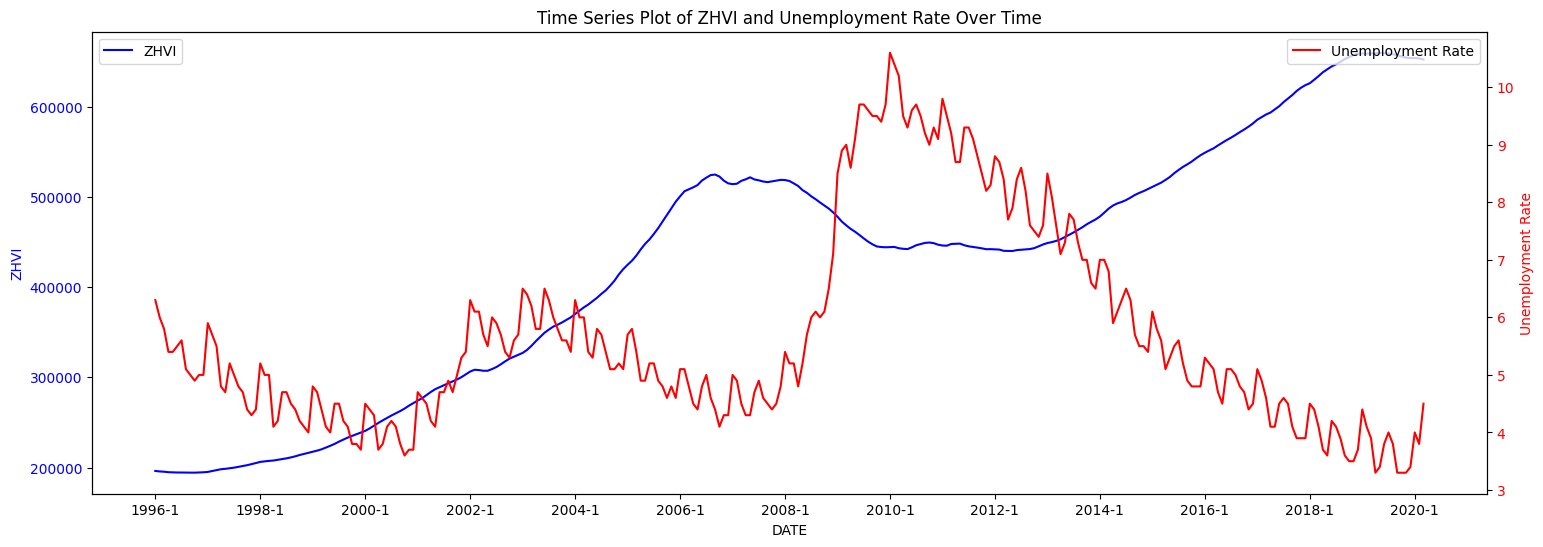

In [ ]:
# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(18, 6))

# Plot the first ZHVI dataset
ax1.plot(full_df['Year-Month'], full_df['ZHVI'], color='blue', label='ZHVI')
ax1.set_xlabel('DATE')
ax1.set_ylabel('ZHVI', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot the Unemployment Rate data
ax2.plot(un_df['TimeIndex'], un_df['unrate'], color='red', label='Unemployment Rate')
ax2.set_ylabel('Unemployment Rate', color='red')
ax2.tick_params(axis='y', labelcolor='red')

x_ticks = np.arange(0, 290, 24)
ax1.set_xticks(x_ticks)

plt.title('Time Series Plot of ZHVI and Unemployment Rate Over Time')

# legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

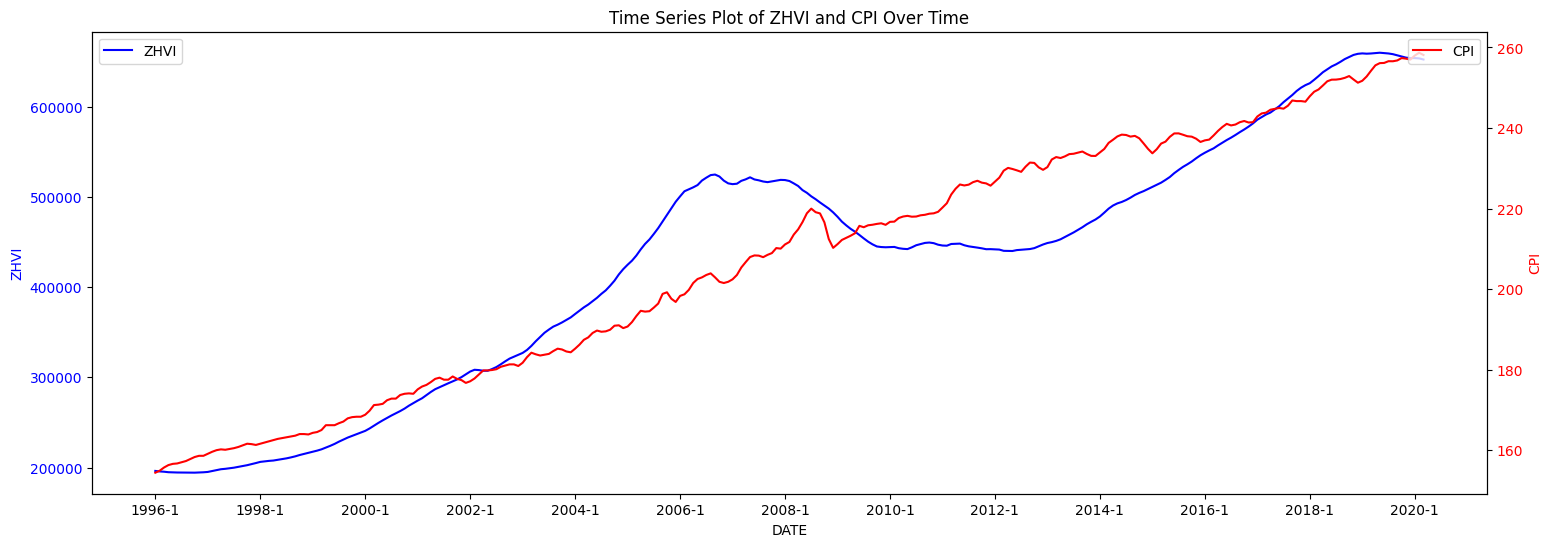

In [ ]:
# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(18, 6))

# Plot the first ZHVI dataset
ax1.plot(full_df['Year-Month'], full_df['ZHVI'], color='blue', label='ZHVI')
ax1.set_xlabel('DATE')
ax1.set_ylabel('ZHVI', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot the Unemployment Rate data
ax2.plot(filtered_cpi_df['TimeIndex'], filtered_cpi_df['CPI'], color='red', label='CPI')
ax2.set_ylabel('CPI', color='red')
ax2.tick_params(axis='y', labelcolor='red')

x_ticks = np.arange(0, 290, 24)
ax1.set_xticks(x_ticks)

plt.title('Time Series Plot of ZHVI and CPI Over Time')

# legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

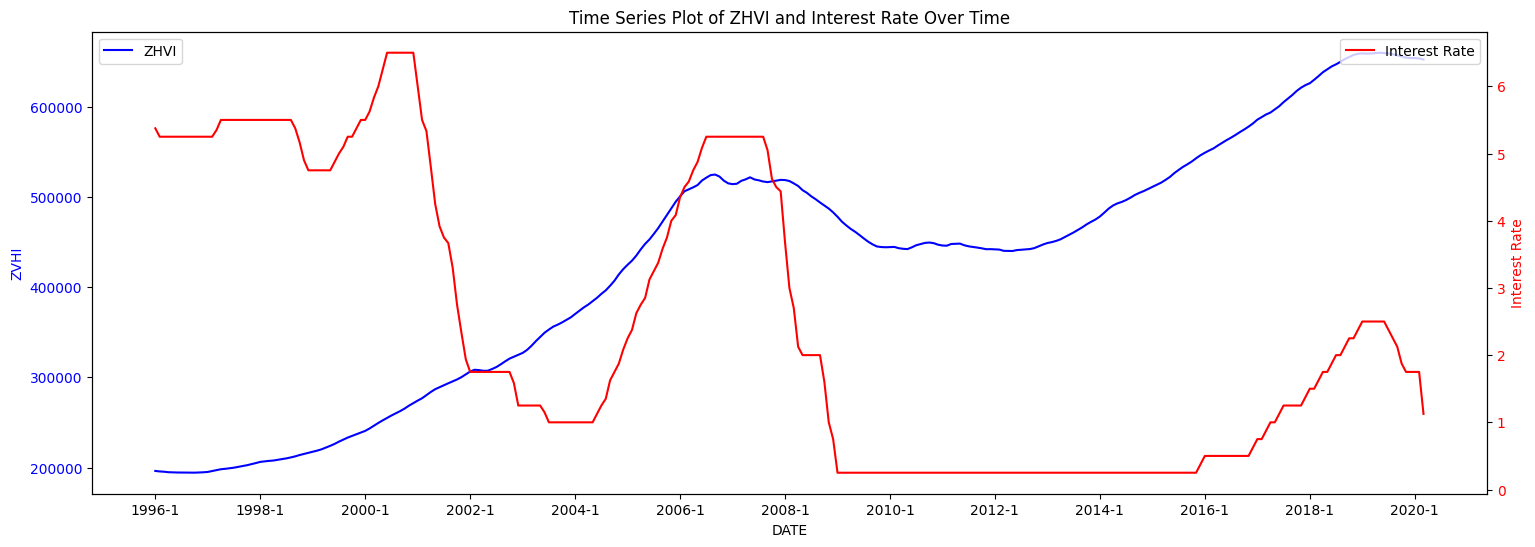

In [ ]:
# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(18, 6))

# Plot the first ZHVI dataset
ax1.plot(full_df['Year-Month'], full_df['ZHVI'], color='blue', label='ZHVI')
ax1.set_xlabel('DATE')
ax1.set_ylabel('ZVHI', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot the Unemployment Rate data
ax2.plot(ir_df['TimeIndex'], ir_df['Value'], color='red', label='Interest Rate')
ax2.set_ylabel('Interest Rate', color='red')
ax2.tick_params(axis='y', labelcolor='red')

x_ticks = np.arange(0, 290, 24)
ax1.set_xticks(x_ticks)

plt.title('Time Series Plot of ZHVI and Interest Rate Over Time')

# legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

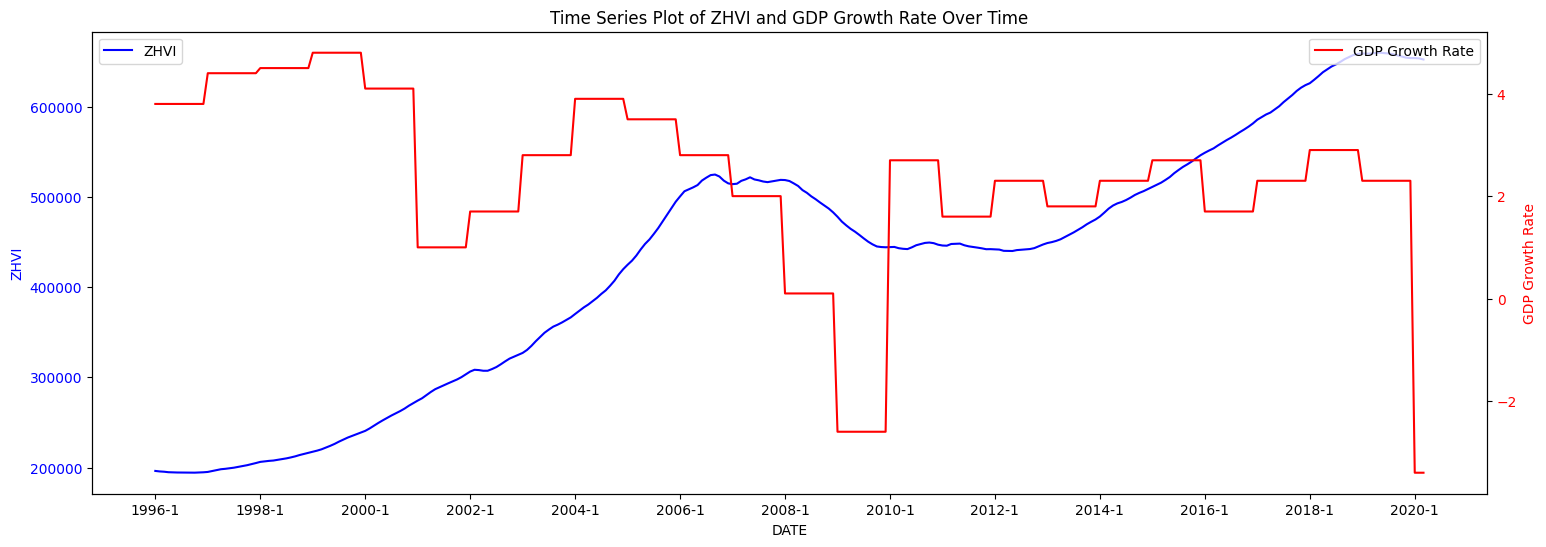

In [ ]:
# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(18, 6))

# Plot the first ZHVI dataset
ax1.plot(full_df['Year-Month'], full_df['ZHVI'], color='blue', label='ZHVI')
ax1.set_xlabel('DATE')
ax1.set_ylabel('ZHVI', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot the Unemployment Rate data
ax2.plot(ir_df['TimeIndex'], gdp_df['GDP Growth'], color='red', label='GDP Growth Rate')
ax2.set_ylabel('GDP Growth Rate', color='red')
ax2.tick_params(axis='y', labelcolor='red')

x_ticks = np.arange(0, 290, 24)
ax1.set_xticks(x_ticks)

plt.title('Time Series Plot of ZHVI and GDP Growth Rate Over Time')

# legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

OLS Root Mean Squared Error (RMSE): 130532.09645357582
OLS Mean Absolute Percentage Error(MAPE): 0.1853761687014548
OLS Mean Absolute Error(MAE): 112483.27602848076
OLS R-squared(R^2): -0.14393633055157418


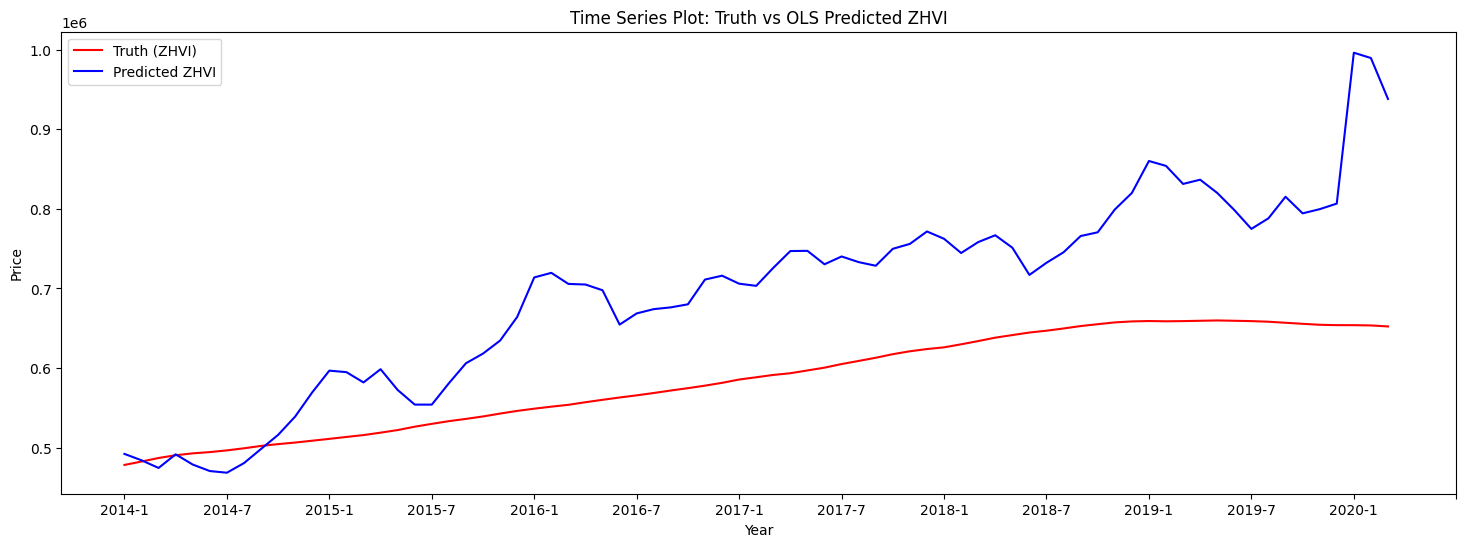

In [ ]:
# Split data into training and test
train = full_df[(full_df['Year'] < 2014) | ((full_df['Year'] == 2013) & (full_df['Month'] <= 12))]
test = full_df[(full_df['Year'] > 2013) | ((full_df['Year'] == 2014) & (full_df['Month'] >= 1))]

# Define features and target
X_train = train[['Year', 'Month', 'TimeIndex', 'Unemployment Rate', 'CPI', 'Interest Rate', 'GDP Growth']]
y_train = train['ZHVI']

# Prediction test
X_test = test[['Year', 'Month', 'TimeIndex','Unemployment Rate', 'CPI','Interest Rate', 'GDP Growth']]

# add polynomial features and scale
scaler = StandardScaler()
poly = PolynomialFeatures(degree=2)

X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)

# add constant
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

# Fit OLS model
model = sm.OLS(y_train, X_train_scaled)
results = model.fit()

predictions = results.predict(X_test_scaled)
test['Predicted_ZHVI'] = predictions

y_test = test['ZHVI']
y_pred = test['Predicted_ZHVI']
OLS_pred = test['Predicted_ZHVI']

# model evaluation
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print(f"OLS Root Mean Squared Error (RMSE): {rmse}")
mape = mean_absolute_percentage_error(y_test, y_pred)
print("OLS Mean Absolute Percentage Error(MAPE):", mape)
MAE = mean_absolute_error(y_test, y_pred)
print("OLS Mean Absolute Error(MAE):", MAE)
r2 = r2_score(y_pred,y_test)
print(f"OLS R-squared(R^2): {r2}")

# Plot truth vs prediction
plt.figure(figsize=(18, 6))
plt.plot(test['Year-Month'], test['ZHVI'], color='red', label='Truth (ZHVI)')
plt.plot(test['Year-Month'], test['Predicted_ZHVI'], color='blue', label='Predicted ZHVI')
plt.xlabel('Year')
plt.ylabel('Price')
x_ticks = np.arange(0, 80, 6)
plt.xticks(x_ticks)
plt.title('Time Series Plot: Truth vs OLS Predicted ZHVI')
plt.legend(loc='upper left')
plt.show()

Sorted Top 10 OLS Regression Coefficients:
                   Feature   Coefficient  Absolute_Coefficient
x24          TimeIndex CPI -7.053306e+06          7.053306e+06
x31                  CPI^2  4.083916e+06          4.083916e+06
x13               Year CPI -1.580288e+06          1.580288e+06
x22            TimeIndex^2  1.550302e+06          1.550302e+06
x6                     CPI -1.441312e+06          1.441312e+06
x11         Year TimeIndex  1.185220e+06          1.185220e+06
x9                  Year^2  1.183376e+06          1.183376e+06
x2                    Year  1.181150e+06          1.181150e+06
x4               TimeIndex  1.181129e+06          1.181129e+06
x28  Unemployment Rate CPI  7.756565e+05          7.756565e+05


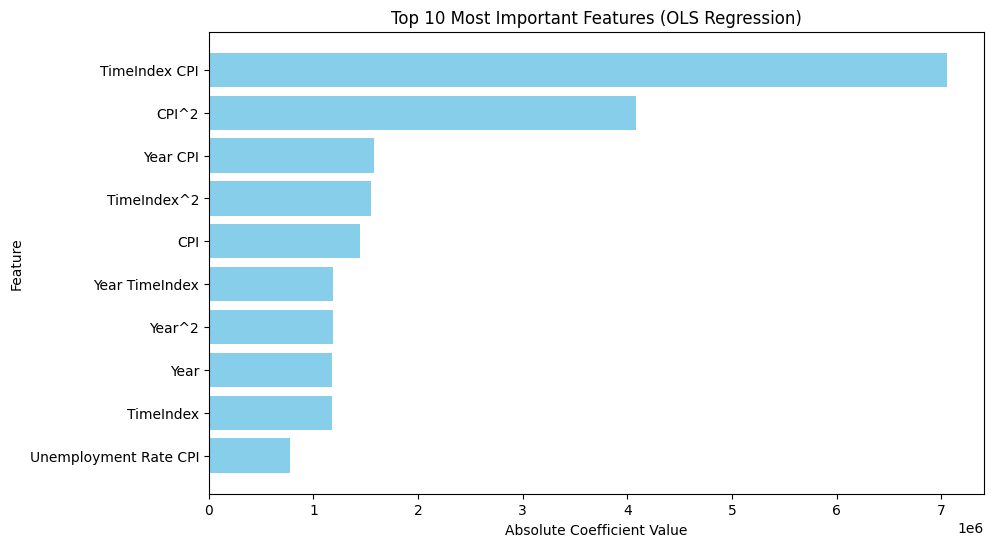

In [ ]:
# Get feature names
feature_names = ['const'] + list(poly.get_feature_names_out(X_train.columns))

# Create dataframe to store coefficients and feature names
coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': results.params
})

# sort features by coeff magnitude
coefficients_df['Absolute_Coefficient'] = np.abs(coefficients_df['Coefficient'])
coefficients_df = coefficients_df.sort_values(by='Absolute_Coefficient', ascending=False)

print("Sorted Top 10 OLS Regression Coefficients:")
print(coefficients_df[0:10])

# plot coeff
plt.figure(figsize=(10, 6))
plt.barh(coefficients_df['Feature'][:10], coefficients_df['Absolute_Coefficient'][:10], color='skyblue')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features (OLS Regression)')
plt.gca().invert_yaxis()
plt.show()

Lowest MAPE: 0.05492470799176251
Lowest Alpha: 50


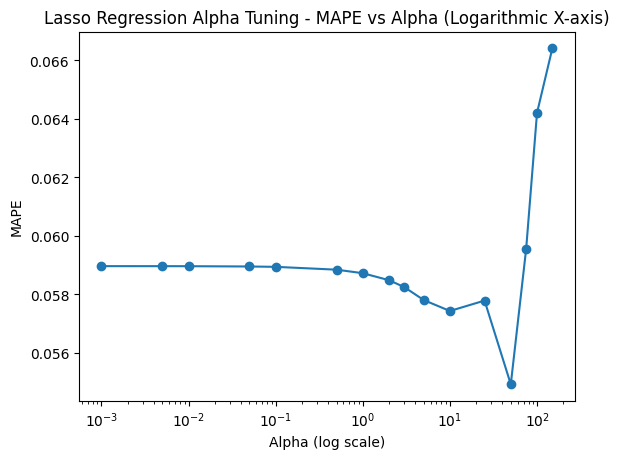



Lasso Root Mean Squared Error (RMSE): 44618.016149679155
Lasso Mean Absolute Percentage Error (MAPE): 0.05492470799176251
Mean Absolute Error (MAE): 34030.374729689334
R-squared(R^2): 0.7853309788737721


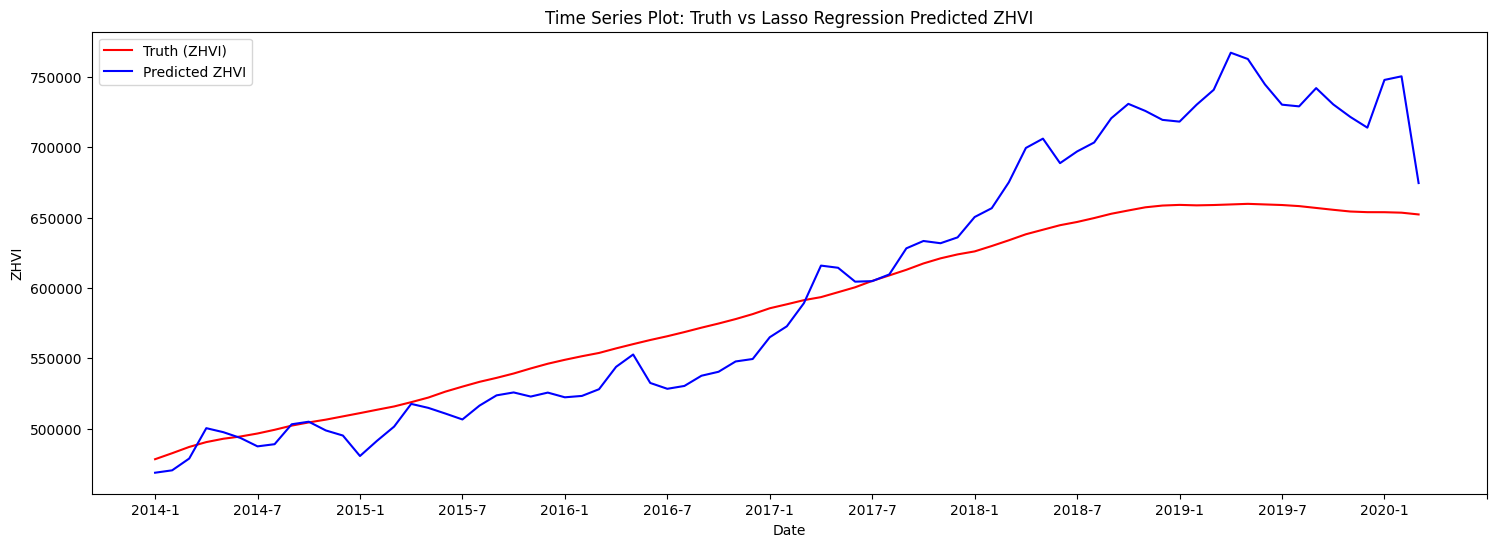

In [ ]:
# Split data into training and test
train = full_df[(full_df['Year'] < 2014) | ((full_df['Year'] == 2013) & (full_df['Month'] <= 12))]
test = full_df[(full_df['Year'] > 2013) | ((full_df['Year'] == 2014) & (full_df['Month'] >= 1))]

# Define features and target
X_train = train[['Year', 'Month', 'TimeIndex', 'Unemployment Rate', 'CPI','Interest Rate', 'GDP Growth']]
y_train = train['ZHVI']

# Prepare test data for prediction
X_test = test[['Year', 'Month', 'TimeIndex', 'Unemployment Rate', 'CPI','Interest Rate', 'GDP Growth']]

# add polynomial features and scale
scaler = StandardScaler()
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)

# Fit Lasso regression model
alphas = [0.001,0.005,0.01, 0.05, 0.1, 0.5, 1, 2, 3, 5, 10,25,50,75,100,150]
results = []
lowest_alpha = alphas[0]
lowest_mape = float('inf')

for alpha in alphas:
  lasso_model = Lasso(alpha=alpha)
  lasso_model.fit(X_train_scaled, y_train)

  # Predict
  predictions = lasso_model.predict(X_test_scaled)
  test['Predicted_ZHVI'] = predictions

  # Model evaluation
  y_test = test['ZHVI']
  y_pred = test['Predicted_ZHVI']
  lasso_pred = test['Predicted_ZHVI']

  mape = mean_absolute_percentage_error(y_test, y_pred)
  results.append(mape)
  if mape < lowest_mape:
    lowest_mape = mape
    lowest_alpha = alpha

print("Lowest MAPE:", lowest_mape)
print("Lowest Alpha:", lowest_alpha)

# Plot hyperparameter tuning
plt.plot(alphas, results, marker='o')
plt.xscale('log')

plt.xlabel('Alpha (log scale)')
plt.ylabel('MAPE')
plt.title('Lasso Regression Alpha Tuning - MAPE vs Alpha (Logarithmic X-axis)')

plt.show()

alpha = lowest_alpha

lasso_model = Lasso(alpha=alpha)
lasso_model.fit(X_train_scaled, y_train)

# Predict
predictions = lasso_model.predict(X_test_scaled)
test['Predicted_ZHVI'] = predictions

# Model evaluation
y_test = test['ZHVI']
y_pred = test['Predicted_ZHVI']
lasso_pred = test['Predicted_ZHVI']

rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print(f"\n\nLasso Root Mean Squared Error (RMSE): {rmse}")
mape = mean_absolute_percentage_error(y_test, y_pred)
print("Lasso Mean Absolute Percentage Error (MAPE):", mape)
MAE = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", MAE)
r2 = r2_score(y_pred,y_test)
print(f"R-squared(R^2): {r2}")

# Plot truth vs prediction
plt.figure(figsize=(18, 6))
plt.plot(test['Year-Month'], test['ZHVI'], color='red', label='Truth (ZHVI)')
plt.plot(test['Year-Month'], test['Predicted_ZHVI'], color='blue', label='Predicted ZHVI')
plt.xlabel('Date')
plt.ylabel('ZHVI')
x_ticks = np.arange(0, 80, 6)
plt.xticks(x_ticks)
plt.title('Time Series Plot: Truth vs Lasso Regression Predicted ZHVI')
plt.legend(loc='upper left')
plt.show()

Sorted Top 10 Lasso Regression Coefficients:
                            Feature    Coefficient  Absolute_Coefficient
22      TimeIndex Unemployment Rate -154296.036934         154296.036934
1                              Year  128222.423511         128222.423511
23                    TimeIndex CPI   89468.745570          89468.745570
21                      TimeIndex^2  -79800.859453          79800.859453
26              Unemployment Rate^2   71651.217699          71651.217699
28  Unemployment Rate Interest Rate   66275.131194          66275.131194
24          TimeIndex Interest Rate   46722.278427          46722.278427
31                CPI Interest Rate  -38094.302067          38094.302067
30                            CPI^2   34600.125584          34600.125584
5                               CPI   29987.267681          29987.267681


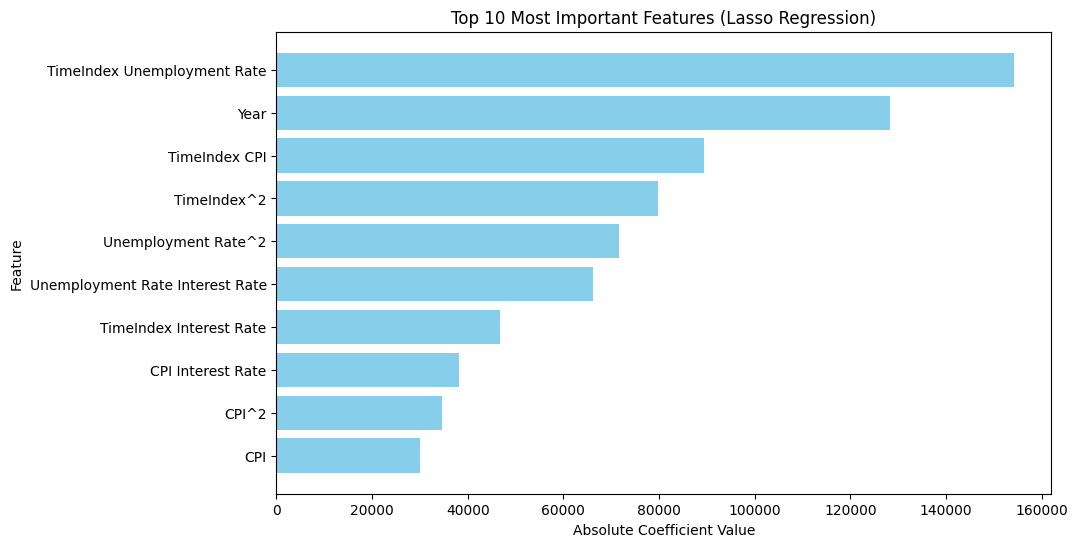

In [ ]:
# Get feature names
feature_names = poly.get_feature_names_out(X_train.columns)

# Create dataframe to store coefficients and feature names
coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lasso_model.coef_
})

# sort features by coeff magnitude
coefficients_df['Absolute_Coefficient'] = np.abs(coefficients_df['Coefficient'])
coefficients_df = coefficients_df.sort_values(by='Absolute_Coefficient', ascending=False)

print("Sorted Top 10 Lasso Regression Coefficients:")
print(coefficients_df[0:10])

# plot coeff
plt.figure(figsize=(10, 6))
plt.barh(coefficients_df['Feature'][:10], coefficients_df['Absolute_Coefficient'][:10], color='skyblue')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features (Lasso Regression)')
plt.gca().invert_yaxis()
plt.show()

Lowest MAPE: 0.04815805234530082
Lowest Alpha: 0.25


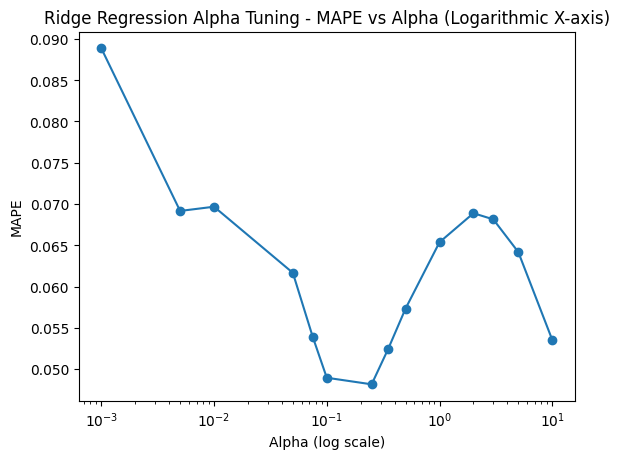



RR Root Mean Squared Error (RMSE): 34586.997710405834
RR Mean Absolute Percentage Error(MAPE): 0.04815805234530082
RR Mean Absolute Error(MAE): 28891.172716798137
R-squared(R^2): 0.846871147352243


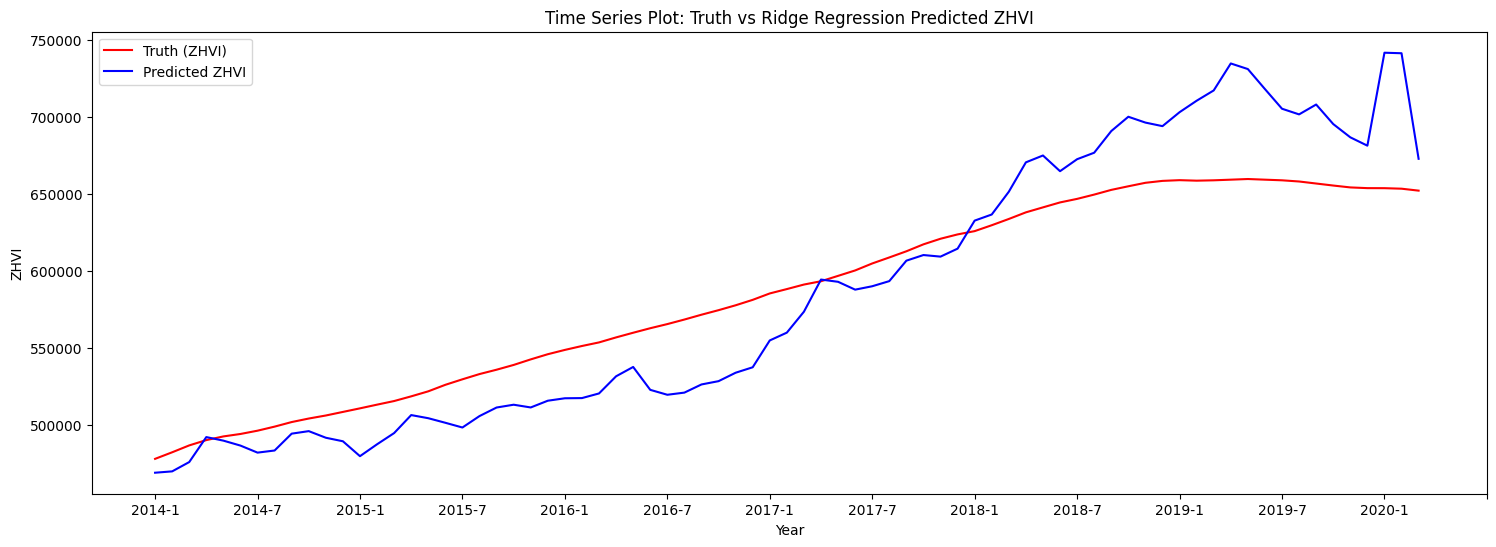

In [ ]:
# Split data into training and test
train = full_df[(full_df['Year'] < 2014) | ((full_df['Year'] == 2013) & (full_df['Month'] <= 12))]
test = full_df[(full_df['Year'] > 2013) | ((full_df['Year'] == 2014) & (full_df['Month'] >= 1))]

# Define features and target
X_train = train[['Year', 'Month', 'TimeIndex', 'Unemployment Rate', 'CPI','Interest Rate', 'GDP Growth']]
y_train = train['ZHVI']

X_test = test[['Year', 'Month', 'TimeIndex', 'Unemployment Rate', 'CPI','Interest Rate', 'GDP Growth']]

# add polynomial features and scale
scaler = StandardScaler()
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)

# Fit Ridge regression model
alphas = [0.001,0.005,0.01, 0.05, 0.075, 0.1, 0.25, 0.35, 0.5, 1, 2, 3, 5, 10]

lowest_alpha = alphas[0]
lowest_mape = float('inf')
results = []
for alpha in alphas:
  ridge_model = Ridge(alpha=alpha)
  ridge_model.fit(X_train_scaled, y_train)

  # Predict
  predictions = ridge_model.predict(X_test_scaled)
  test['Predicted_ZHVI'] = predictions

  # Model evaluation
  y_test = test['ZHVI']
  y_pred = test['Predicted_ZHVI']
  ridge_pred = test['Predicted_ZHVI']

  mape = mean_absolute_percentage_error(y_test, y_pred)
  results.append(mape)
  if mape < lowest_mape:
    lowest_mape = mape
    lowest_alpha = alpha

print("Lowest MAPE:", lowest_mape)
print("Lowest Alpha:", lowest_alpha)

# Plot hyperparameter tuning
plt.plot(alphas, results, marker='o')
plt.xscale('log')

plt.xlabel('Alpha (log scale)')
plt.ylabel('MAPE')
plt.title('Ridge Regression Alpha Tuning - MAPE vs Alpha (Logarithmic X-axis)')

plt.show()

alpha = lowest_alpha
ridge_model = Ridge(alpha=alpha)
ridge_model.fit(X_train_scaled, y_train)

# Predict
predictions = ridge_model.predict(X_test_scaled)
test['Predicted_ZHVI'] = predictions

# Model evaluation
y_test = test['ZHVI']
y_pred = test['Predicted_ZHVI']
ridge_pred = test['Predicted_ZHVI']

rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print(f"\n\nRR Root Mean Squared Error (RMSE): {rmse}")
mape = mean_absolute_percentage_error(y_test, y_pred)
print("RR Mean Absolute Percentage Error(MAPE):", mape)
MAE = mean_absolute_error(y_test, y_pred)
print("RR Mean Absolute Error(MAE):", MAE)
r2 = r2_score(y_pred,y_test)
print(f"R-squared(R^2): {r2}")

# Plot truth vs prediction
plt.figure(figsize=(18, 6))
plt.plot(test['Year-Month'], test['ZHVI'], color='red', label='Truth (ZHVI)')
plt.plot(test['Year-Month'], test['Predicted_ZHVI'], color='blue', label='Predicted ZHVI')
plt.xlabel('Year')
plt.ylabel('ZHVI')
x_ticks = np.arange(0, 80, 6)
plt.xticks(x_ticks)
plt.title('Time Series Plot: Truth vs Ridge Regression Predicted ZHVI')
plt.legend(loc='upper left')
plt.show()

Sorted Top 10 Ridge Regression Coefficients:
                            Feature    Coefficient  Absolute_Coefficient
22      TimeIndex Unemployment Rate -109178.576829         109178.576829
28  Unemployment Rate Interest Rate   59548.087563          59548.087563
5                               CPI   54636.320560          54636.320560
12                         Year CPI   52733.852309          52733.852309
27            Unemployment Rate CPI  -48590.347941          48590.347941
26              Unemployment Rate^2   45311.048503          45311.048503
24          TimeIndex Interest Rate   40266.286996          40266.286996
3                         TimeIndex   37172.836936          37172.836936
1                              Year   37166.437453          37166.437453
8                            Year^2   36844.519700          36844.519700


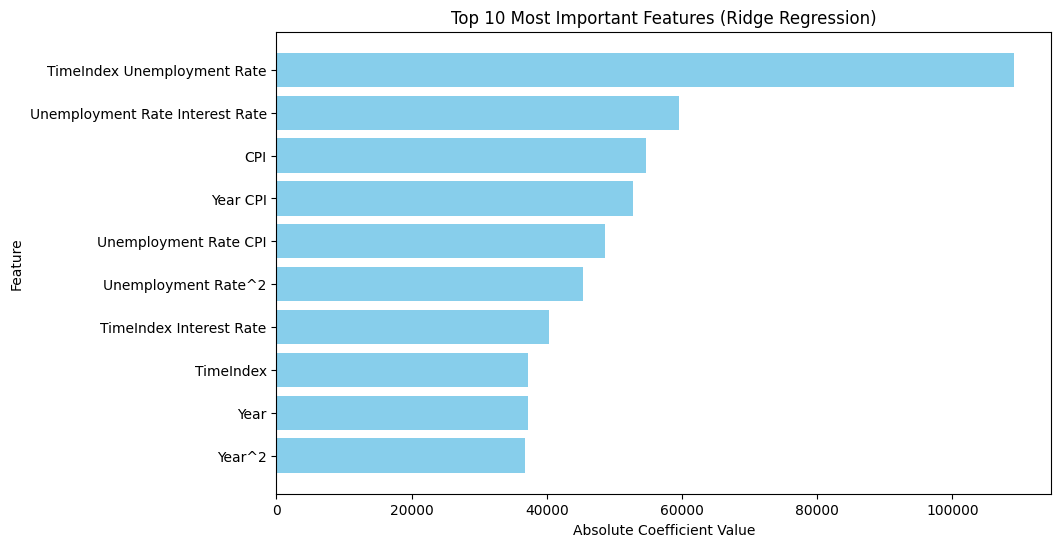

In [ ]:
# Get feature names
feature_names = poly.get_feature_names_out(X_train.columns)

# Create dataframe to store coefficients and feature names
coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': ridge_model.coef_
})

# sort features by coeff magnitude
coefficients_df['Absolute_Coefficient'] = np.abs(coefficients_df['Coefficient'])
coefficients_df = coefficients_df.sort_values(by='Absolute_Coefficient', ascending=False)

print("Sorted Top 10 Ridge Regression Coefficients:")
print(coefficients_df[0:10])

# plot coeff
plt.figure(figsize=(10, 6))
plt.barh(coefficients_df['Feature'][:10], coefficients_df['Absolute_Coefficient'][:10], color='skyblue')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features (Ridge Regression)')
plt.gca().invert_yaxis()
plt.show()

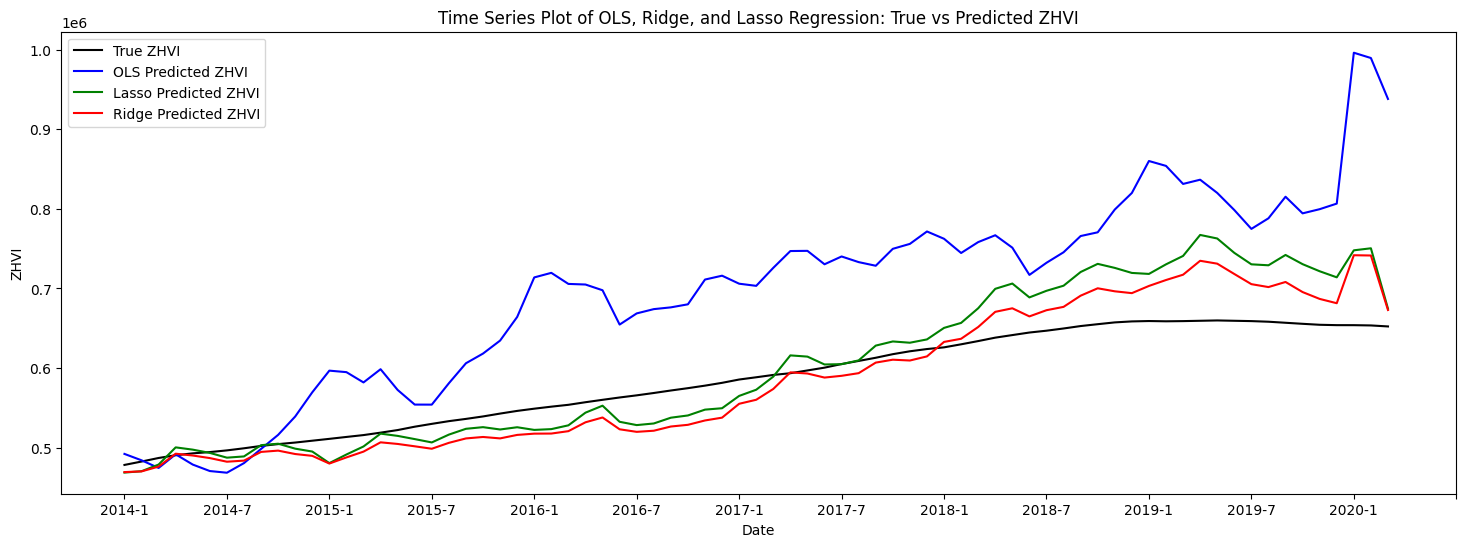

In [ ]:
plt.figure(figsize=(18, 6))
plt.plot(test['Year-Month'], test['ZHVI'], color='black', label='True ZHVI')
plt.plot(test['Year-Month'], OLS_pred, color='blue', label='OLS Predicted ZHVI')
plt.plot(test['Year-Month'], lasso_pred, color='green', label='Lasso Predicted ZHVI')
plt.plot(test['Year-Month'], ridge_pred, color='red', label='Ridge Predicted ZHVI')

plt.xlabel('Date')
plt.ylabel('ZHVI')
x_ticks = np.arange(0, 80, 6)
plt.xticks(x_ticks)
plt.title('Time Series Plot of OLS, Ridge, and Lasso Regression: True vs Predicted ZHVI')

plt.legend(loc='upper left')

plt.show()

milestone 2

In [1]:
!pip install -q streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.8 MB/s eta 0:00:00


In [2]:
%%writefile app.py

import streamlit as st

st.write('Hello, *World!* :sunglasses:')

Writing app.py


In [3]:
!npm install localtunnel


⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦
added 22 packages in 4s
⠦
⠦3 packages are looking for funding
⠦  run `npm fund` for details
⠦

In [10]:
!streamlit run app.py &>/content/logs.txt & npx localtunnel --port 8501 & curl ipv4.icanhazip.com



34.16.215.149
⠙your url is: https://neat-baboons-shake.loca.lt


In [7]:
import urllib
print("Password/Enpoint IP for localtunnel is:",urllib.request.urlopen('https://ipv4.icanhazip.com').read().decode('utf8').strip("\n"))

Password/Enpoint IP for localtunnel is: 34.16.215.149
